## Fashion MNIST Classification with SGD and Adaptive Step Sizes

This notebook demonstrates **binary classification** using **Stochastic Gradient Descent (SGD)**
on the Fashion MNIST dataset. The focus is on experimenting with different **adaptive step size policies**
to evaluate their effect on convergence and classification accuracy.

Key features include:
- Custom logistic loss and gradient implementation
- Data preparation for binary classification (two selected classes)
- SGD with various learning rate strategies: constant, diminishing, and Polyak-style
- Misclassification error evaluation


### Data Preparation and SGD Optimization

This section includes:
- `prepare_fashion_mnist`: loads the Fashion MNIST dataset, filters two selected classes, rescales,
adds an offset/bias term, and applies a sign flip for binary logistic regression.
- `sgd_mlogistic`: runs stochastic gradient descent with a user-defined step size function.


In [257]:
# prepare_fashion_mnist(class1, class2) -> x_train, y_train, x_test, y_test
# class1, class2: 0~9
# read fashion mnist from file
# get trainX, trainY, testX and testY from file that corresponds to class1 and class2
# find q = average value of all pixels across all images in trainX
# append q to every image in trainX and testX as the 785th pixel/element - offset term - serves as regularization and bias
# flip sign of class1 in trainY and testY
# return x_train, y_train, x_test, y_test
from scipy.io import loadmat
import numpy as np
import pandas as pd
import random

def prepare_fashion_mnist(class1, class2):

    # load data
    data = loadmat('fashion_mnist.mat')
    trainX = data['trainX_uint8']
    trainY = data['trainY_uint8']
    testX = data['testX_uint8']
    testY = data['testY_uint8']

    # filter out class1 and class2

    train_indices = np.where((trainY == class1) | (trainY == class2))
    trainX = trainX[:,train_indices[0]]
    trainY = trainY[train_indices[0]]

    test_indices = np.where((testY == class1) | (testY == class2))
    testX = testX[:,test_indices[0]]
    testY = testY[test_indices[0]]

    #convert to float
    trainX = trainX.astype(float)
    testX = testX.astype(float)

    # find q
    q = np.mean(trainX)

    # append q to every image in trainX and testX as the 785th pixel/element
    trainX = np.append(trainX, q * np.ones((1, trainX.shape[1])), axis=0)
    testX = np.append(testX, q * np.ones((1, testX.shape[1])), axis=0)

    # flip sign of class1 in trainX and testX
    class1_indices = np.where((trainY == class1))
    trainX[:,class1_indices[0]] = -trainX[:,class1_indices[0]]

    class1_indices = np.where((testY == class1))
    testX[:,class1_indices[0]] = -testX[:,class1_indices[0]]

    return trainX.T, trainY.T, testX.T, testY.T


def sgd_mlogistic(trainXr, gamma, stepsizefunc, numit):

    #initialize weights
    x = np.zeros((trainXr.shape[1], 1))
    # random.seed(42)
    x_list = []
    for k in range(numit):
        
        # choose random index
        i = random.randint(0, trainXr.shape[0]-1)
        ai = trainXr[i, :].reshape(-1,1)
        alpha = stepsizefunc(ai, x, k)
        grad = gradient_f(x, ai, gamma)
        x = x - alpha*grad
        x_list.append(x)

    return np.mean(x_list, axis=0)



### Helper Functions

This section defines:
- Logistic loss (`f_x`) and its gradient (`gradient_f`)
- Step size policies including diminishing steps and Polyak step sizes (`stoch_polyak`)
- Supporting math utilities including Newton's method and psi/phi functions
- Misclassification error computation for evaluating model performance


In [258]:
## HELPER FUNCTIONS
import math

def P(c):
    return lambda t: 1 - 4 * t + 4 * (t**2) - 4 * c * (t**3) + 4 * c * (t**4)


def P_prime(c):
    return lambda t: -4 + 8 * t - 12 * c * (t**2) + 16 * c * (t**3)


def newton_method_on_P(c):
    initial_guess = min(0.5, (4 * c) ** (-1 / 3))
    last_x = initial_guess

    for i in range(20):
        x = last_x - P(c)(last_x) / P_prime(c)(last_x)
        last_x = x
    return last_x

def gradient_f(x, a, gamma):
    # Compute the gradient of f with respect to x for a single data point a
    gradient = (0.5 + 0.5 * np.dot(a.T, x) / np.sqrt(1 + np.dot(a.T, x)**2)) * a
    gradient += gamma * x  # Add regularization term
    return gradient

def f_x(x, a, gamma):
    reg_term = (gamma / 2) * np.linalg.norm(x)**2

    t = np.dot(a.T, x)
    psi_t = psi(t)
    return psi_t + reg_term


def find_min_of_f(a_norm_squared, gamma):
    c = (a_norm_squared**2) / (gamma**2)
    t_star = newton_method_on_P(c)
    theta_star = t_star / gamma
    psi = lambda t: t / 2 + math.sqrt(1 + t**2) / 2
    return theta_star, psi(-a_norm_squared * theta_star) + (
        gamma / 2
    ) * a_norm_squared * (theta_star**2)

def psi(t):
    return t / 2 + np.sqrt(1 + t**2) / 2

def phi_1(a, x, k, gamma):
    L = 4*gamma**2

    return (gamma*1e-2)/L

def phi_2(a, x, k, gamma):
    L = 4*gamma**2

    return (gamma*1e-5)/L

def phi_3(a, x, k, gamma):
    L = 4*gamma**2
    m = gamma
    c = L/(m**2)

    return 1/(m*(c + 0.75*k))

def stoch_polyak(a, x, gamma, gammab=1e4):
    
    _, f_min = find_min_of_f(np.linalg.norm(a)**2, gamma)
    f_current = f_x(x, a, gamma)
    squared_norm_grad = np.linalg.norm(gradient_f(x, a, gamma))**2
    alpha = min(gammab, 2 * (f_current - f_min) / squared_norm_grad)
    # print(alpha)
    
    return alpha

def calculate_error(dataXr, x):
    predictions = np.dot(dataXr, x)
    # Determine misclassified points (nonnegative means misclassified)
    misclassified = predictions[predictions >= 0]
    error_rate = len(misclassified)/len(predictions)

    return error_rate, predictions



In [259]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

def display_misclassified_image(dataXr, dataYr, x,actual_labels, class1, class2):
    """
    Display a misclassified image with a label showing the actual and misclassified classes.
    
    Parameters:
    - dataXr: The test dataset (or train dataset), including the augmented pixel for offset.
    - dataYr: The labels of the test dataset.
    - x: The model weights from sgd_mlogistic.
    - actual_labels: Original labels for class1 and class2 (e.g., 0 for T-shirt, 9 for ankle-boot).
    - class1, class2: The integer class labels (for binary classification).
    """
    # Get predictions
    predictions = np.dot(dataXr, x).T[0]
    dataYr = dataYr.reshape(-1)

    # Find a misclassified index
    for i, pred in enumerate(predictions):
        # Check misclassification condition: prediction is incorrect if sign doesn't match the intended class
        if pred >= 0:
            misclassified_index = i
            break
    
    # Retrieve the misclassified image and label

    misclassified_image = dataXr[misclassified_index, :784].reshape(28, 28)  # Remove the augmented pixel
    actual_label = dataYr[misclassified_index]
    error_label = class1 if actual_label == class2 else class2

    # Create a PIL image for adding text label
    image = Image.fromarray((misclassified_image * 255).astype(np.uint8))  # Scale to 0-255 for display
    image = image.convert("L")  # Convert to grayscale
    label_text = f"Actual: {actual_labels[actual_label]}, Misclassified as: {actual_labels[error_label]}"


    # Display the image
    plt.imshow(image, cmap="gray")

    plt.axis("off")
    plt.title(label_text, pad=10)  # `pad` to add space between the image and title
    plt.show()


In [270]:
def driver(ss_func, numit, class1, class2, gamma, actual_labels, display=False):
    [x_train, y_train, x_test, y_test] = prepare_fashion_mnist(class1, class2)
    train_errors = []
    test_errors = []
    for i in range(3):

      x = sgd_mlogistic(x_train, gamma, ss_func, numit)
      train_error, _ = calculate_error(x_train, x)
      # print("TRAIN ERROR: ", train_error)
      train_errors.append(train_error)
      #test error
      test_error, test_pred = calculate_error(x_test, x)
      # print("TEST ERROR: ", test_error)
      test_errors.append(test_error)

    min_train_error = min(train_errors)
    max_train_error = max(train_errors)
    mean_train_error = np.mean(train_errors)
    min_test_error = min(test_errors)
    max_test_error = max(test_errors)
    mean_test_error = np.mean(test_errors)
    print(f"Min Train Error: {min_train_error}")
    print(f"Max Train Error: {max_train_error}")
    print(f"Mean Train Error: {mean_train_error}")
    print(f"Min Test Error: {min_test_error}")
    print(f"Max Test Error: {max_test_error}")
    print(f"Mean Test Error: {mean_test_error}")
    if display:
      display_misclassified_image(x_test, y_test, x, actual_labels, class1=class1, class2=class2)
    return min_train_error, max_train_error, mean_train_error, min_test_error, max_test_error, mean_test_error

Class Pair: Ankle-Boot vs T-shirt
Number of Iterations: 50
Step Function: 1
Min Train Error: 0.006666666666666667
Max Train Error: 0.023916666666666666
Mean Train Error: 0.014666666666666666
Min Test Error: 0.008
Max Test Error: 0.026
Mean Test Error: 0.016


Number of Iterations: 5000
Step Function: 1
Min Train Error: 0.00125
Max Train Error: 0.0015
Mean Train Error: 0.0013611111111111113
Min Test Error: 0.001
Max Test Error: 0.0025
Mean Test Error: 0.0016666666666666668


Number of Iterations: 50
Step Function: 2
Min Train Error: 0.0025
Max Train Error: 0.011333333333333334
Mean Train Error: 0.006916666666666667
Min Test Error: 0.002
Max Test Error: 0.011
Mean Test Error: 0.007333333333333333


Number of Iterations: 5000
Step Function: 2
Min Train Error: 0.0009166666666666666
Max Train Error: 0.0011666666666666668
Mean Train Error: 0.0010277777777777778
Min Test Error: 0.0005
Max Test Error: 0.001
Mean Test Error: 0.0008333333333333334


Number of Iterations: 50
Step Function: 3
Min 

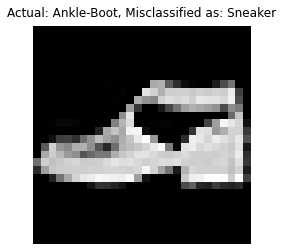

In [271]:
gamma = 2.0
gamma_b = 1e4
stepsizefunc_1 = lambda x, y, z: phi_1(x,y,z, gamma)
stepsizefunc_2 = lambda x, y, z: phi_2(x,y,z, gamma)
stepsizefunc_3 = lambda x, y, z: phi_3(x,y,z, gamma)
stepsizefunc_4 = lambda x, y, z: stoch_polyak(x,y, gamma, gamma_b)
step_funcs = [stepsizefunc_1, stepsizefunc_2, stepsizefunc_3, stepsizefunc_4]
class_pairs = [[9,0], [9,7]]
actual_labels = {9: "Ankle-Boot", 0: "T-shirt", 7:"Sneaker"}
numits = [50, 5000]
num_runs = 0
for class_pair in class_pairs:
    
    print(f"Class Pair: {actual_labels[class_pair[0]]} vs {actual_labels[class_pair[1]]}")
    for f, step_func in enumerate(step_funcs):
        for numit in numits:
            if num_runs == 15:
                disp = True
            else:
                disp = False
            print(f"Number of Iterations: {numit}")
            print(f"Step Function: {f+1}")
            min_train_error, max_train_error, mean_train_error, min_test_error, max_test_error, mean_test_error = driver(step_func, numit, class_pair[0], class_pair[1], gamma, actual_labels, display=disp)
            print("\n")
            num_runs += 1




